# Univariate time series classification with sktime

From: https://www.sktime.org/en/latest/examples/02_classification_univariate.html

## Overview

In this notebook, we will use sktime for univariate time series classification. Here, we have a single time series variable and an associated label for multiple instances. The goal is to find a classifier that can learn the relationship between time series and label and accurately predict the label of new series.

When you have multiple time series variables and want to learn the relationship between them and a label, you can take a look at our [multivariate time series classification notebook](https://github.com/alan-turing-institute/sktime/blob/main/examples/03_classification_multivariate.ipynb).

## [Preliminaries](https://www.sktime.org/en/latest/examples/02_classification_univariate.html#Preliminaries)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope

## [Load data](https://www.sktime.org/en/latest/examples/02_classification_univariate.html#Load-data)

In this notebook, we use the [arrow head problem](https://timeseriesclassification.com/description.php?Dataset=ArrowHead).

The arrowhead dataset consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow.

<img src="https://www.sktime.org/en/latest/_images/arrow-heads.png" width=400/>

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="https://www.sktime.org/en/latest/_images/from-shapes-to-time-series.png" width=400/>

### Data representation

Throughout sktime, the expected data format is a `pd.DataFrame`, but in a slightly unusual format. A single column can contain not only primitives (floats, integers or strings), but also entire time series in form of a `pd.Series` or `np.array`.

For more details on our choice of data container, see this [wiki entry](https://github.com/alan-turing-institute/sktime/wiki/Time-series-data-container).

In [4]:
X, y = load_arrow_head(return_X_y=True)

In [5]:
print(type(X), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [6]:
print(X.shape, y.shape)

(211, 1) (211,)


In [7]:
X[:3]

,dim_0
0,0 -1.9630 1 -1.9578 2 -1.9561 3 ...
1,0 -1.7746 1 -1.7740 2 -1.7766 3 ...
2,0 -1.8660 1 -1.8420 2 -1.8350 3 ...


In [8]:
y[:3]

0    0
1    1
2    2
dtype: object

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


In [10]:
# univariate time series input data
X_train.head()

,dim_0
140,0 -1.6633 1 -1.6207 2 -1.5787 3 ...
34,0 -2.0417 1 -2.0572 2 -2.0522 3 ...
138,0 -1.7677 1 -1.7506 2 -1.7444 3 ...
11,0 -1.8337 1 -1.8277 2 -1.7764 3 ...
130,0 -1.7761 1 -1.7900 2 -1.7530 3 ...


In [11]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [58 48 52]


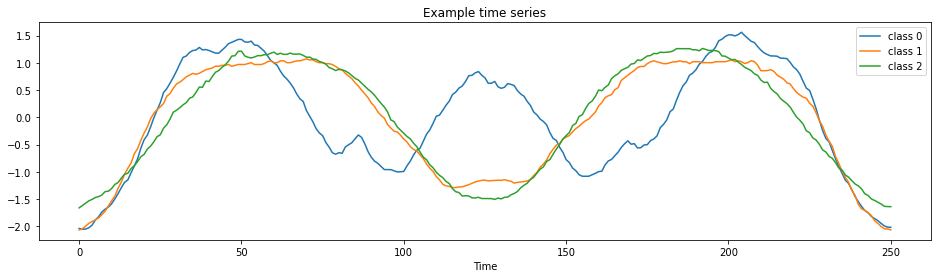

In [12]:
# Plot.

fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

### Why not just use scikit-learn?

We can still use scikit-learn, but using scikit-learn comes with some implicit modelling choices.

### Reduction: from time-series classification to tabular classification

To use scikit-learn, we have to convert the data into the required tabular format. There are different ways we can do that:

#### Treating time points as separate features (tabularisation)

Alternatively, we could bin and aggregate observations in time bins of different length.

In [13]:
# ‼️ NOTE: sktime.datatypes is not yet available in sktime 0.7.0, install from source to run this!

from sklearn.ensemble import RandomForestClassifier

from sktime.datatypes._panel._convert import from_nested_to_2d_array  # NOTE.

X_train_tab = from_nested_to_2d_array(X_train)
X_test_tab = from_nested_to_2d_array(X_test)
X_train_tab.head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
140,-1.6633,-1.6207,-1.5787,-1.5331,-1.5078,-1.4722,-1.4566,-1.4268,-1.3647,-1.3578,...,-1.3144,-1.4041,-1.4360,-1.4983,-1.5269,-1.5591,-1.5914,-1.6347,-1.6393,-1.6408
34,-2.0417,-2.0572,-2.0522,-2.0291,-1.9790,-1.8854,-1.8259,-1.7399,-1.6878,-1.6484,...,-1.6357,-1.7135,-1.7497,-1.8198,-1.8595,-1.8966,-1.9478,-1.9948,-2.0175,-2.0206
138,-1.7677,-1.7506,-1.7444,-1.7378,-1.7401,-1.7149,-1.7006,-1.6687,-1.6465,-1.6050,...,-1.5569,-1.5907,-1.6087,-1.6451,-1.6871,-1.6965,-1.7349,-1.7454,-1.7659,-1.7817
11,-1.8337,-1.8277,-1.7764,-1.7744,-1.7168,-1.6714,-1.6217,-1.6134,-1.5546,-1.4931,...,-1.5613,-1.6203,-1.6704,-1.7176,-1.7567,-1.7944,-1.8134,-1.8150,-1.8327,-1.8169
130,-1.7761,-1.7900,-1.7530,-1.7400,-1.7126,-1.6836,-1.6511,-1.6107,-1.5644,-1.5603,...,-1.5663,-1.5975,-1.6334,-1.6745,-1.6919,-1.7242,-1.7511,-1.7765,-1.7878,-1.7908


In [14]:
# let's get a baseline for comparison
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train_tab, y_train)
classifier.score(X_test_tab, y_test)

0.4339622641509434

In [15]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_tab, y_train)
y_pred = classifier.predict(X_test_tab)
accuracy_score(y_test, y_pred)

0.8490566037735849

In [16]:
from sklearn.pipeline import make_pipeline

# with sktime, we can write this as a pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier = make_pipeline(
    Tabularizer(),  # ⚠️ NOTE: We're able to pass Tabularizer into sklearn pipeline without issue.
    RandomForestClassifier()
)

classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.8679245283018868

What’s the implicit modelling choice here?

We treat each observation as a separate feature and thus ignore they are ordered in time. *A tabular algorithm cannot make use of the fact that features are ordered in time*, i.e. if we changed the order of the features, the fitted model and predictions wouldn’t change. Sometimes this works well, sometimes it doesn’t.

### Feature extraction

Another modelling choice: we could extract features from the time series and then use the features to fit our tabular classifier. 

Here we use [tsfresh](https://tsfresh.readthedocs.io/) for automatic feature extraction.

In [17]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [18]:
transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)
extracted_features.head()

/mnt/space/miniconda3/envs/py38_playaround-sk_sktime-source/lib/python3.8/site-packages/sktime/transformations/panel/tsfresh.py:163: UserWarning: tsfresh requires a unique index, but found non-unique. To avoid this warning, please make sure the index of X contains only unique values.
  warn(
Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 88.49it/s]


,dim_0__sum_values,dim_0__median,dim_0__mean,dim_0__length,dim_0__standard_deviation,dim_0__variance,dim_0__root_mean_square,dim_0__maximum,dim_0__minimum
0,-0.000011,0.187940,-4.382470e-08,251.0,0.998003,0.996011,0.998003,1.2654,-1.6633
1,-0.000034,0.018880,-1.354582e-07,251.0,0.998004,0.996012,0.998004,1.5626,-2.0572
2,0.000139,0.063572,5.537849e-07,251.0,0.998007,0.996019,0.998007,1.3282,-1.7817
3,-0.000069,0.090341,-2.749004e-07,251.0,0.998006,0.996016,0.998006,1.4344,-1.8337
4,-0.000053,0.258650,-2.111554e-07,251.0,0.998002,0.996007,0.998002,1.1626,-1.7908


In [19]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

/mnt/space/miniconda3/envs/py38_playaround-sk_sktime-source/lib/python3.8/site-packages/sktime/transformations/panel/tsfresh.py:163: UserWarning: tsfresh requires a unique index, but found non-unique. To avoid this warning, please make sure the index of X contains only unique values.
  warn(
Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
/mnt/space/miniconda3/envs/py38_playaround-sk_sktime-source/lib/python3.8/site-packages/sktime/transformations/panel/tsfresh.py:163: UserWarning: tsfresh requires a unique index, but found non-unique. To avoid this warning, please make sure the index of X contains only unique values.
  warn(
Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


0.8679245283018868

What’s the implicit modelling choice here?

Instead of working in the domain of the time series, we extract features from time series and choose to work in the domain of the features. Again, sometimes this works well, sometimes it doesn’t. The main difficulty is finding discriminative features for the classification problem.

## [Time series classification with sktime](https://www.sktime.org/en/latest/examples/02_classification_univariate.html#Time-series-classification-with-sktime)

`sktime` has a number of specialised time series algorithms.

### Time series forest

Time series forest is a modification of the random forest algorithm to the time series setting:

1. Split the series into multiple random intervals,
2. Extract features (mean, standard deviation and slope) from each interval,
3. Train a decision tree on the extracted features,
4. Ensemble steps 1 - 3.

For more details, take a look at the [paper](https://www.sciencedirect.com/science/article/pii/S0020025513001473).

In sktime, we can write:

In [20]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor

In [21]:
steps = [
    # Feature extractor:
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    # Classifier:
    (
        "clf", 
        DecisionTreeClassifier()
    ),
]
time_series_tree = Pipeline(steps)

We can directly fit and evaluate the single time series tree (which is simply a pipeline).

In [22]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.8301886792452831

For *time series forest*, we can simply use the single tree as the base estimator in the forest ensemble.

In [23]:
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

Fit and obtain the out-of-bag score:

In [24]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.8544303797468354


In [25]:
tsf = ComposableTimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.8867924528301887

We can also obtain feature importances for the different features and intervals that the algorithms looked at and plot them in a feature importance graph over time.

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Feature importance')]

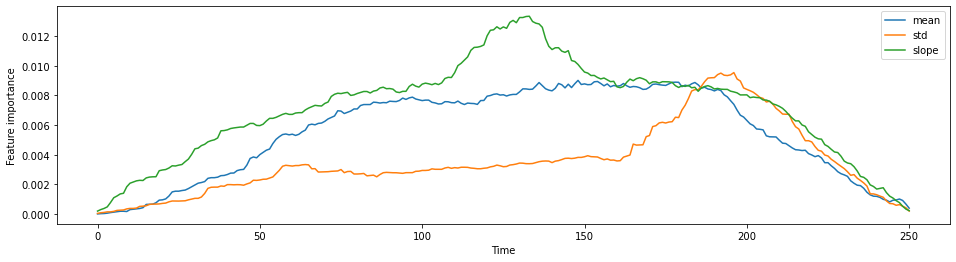

In [26]:
fi = tsf.feature_importances_
# renaming _slope to slope.
fi.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance")

## More about feature importances

The feature importances method is based on the example showcased in [this paper](https://arxiv.org/abs/1302.2277).

> In addition to the feature importances method [available in `scikit-learn`](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), our method collects the feature importances values from each estimator for their respective intervals, calculates the sum of feature importances values on each timepoint, and normalises the values first by the number of estimators and then by the number of intervals.

As a result, the temporal importance curves can be plotted, as shown in the previous example.

‼️ Please note that this method currently **supports only one particular structure of the TSF**, where `RandomIntervalFeatureExtractor()` is used in the pipeline, or simply the default `TimeSeriesForestClassifier()` setting. For instance, two possible approaches could be:

<AxesSubplot:>

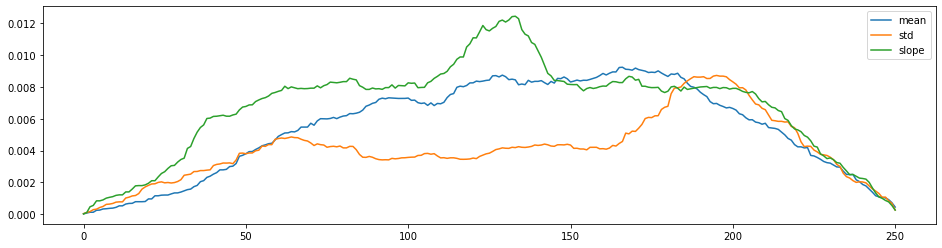

In [27]:
# Method 1: Default time-series forest classifier
tsf1 = ComposableTimeSeriesForestClassifier()
tsf1.fit(X_train, y_train)
fi1 = tsf1.feature_importances_
# renaming _slope to slope.
fi1.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi1.plot(ax=ax)

<AxesSubplot:>

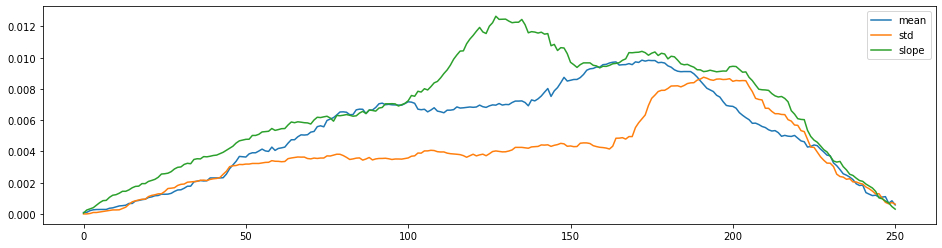

In [29]:
# Method 2: Pipeline
features = [np.mean, np.std, _slope]
steps = [
    ("transform", RandomIntervalFeatureExtractor(features=features)),
    ("clf", DecisionTreeClassifier()),
]
base_estimator = Pipeline(steps)
tsf2 = ComposableTimeSeriesForestClassifier(estimator=base_estimator)
tsf2.fit(X_train, y_train)
fi2 = tsf2.feature_importances_
# renaming _slope to slope.
fi2.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi2.plot(ax=ax)

### RISE

Another popular variant of time series forest is the so-called *Random Interval Spectral Ensemble (RISE)*, which makes use of several series-to-series feature extraction transformers, including:

* Fitted auto-regressive coefficients,
* Estimated autocorrelation coefficients,
* Power spectrum coefficients.

In [30]:
from sktime.classification.interval_based import RandomIntervalSpectralForest

In [31]:
rise = RandomIntervalSpectralForest(n_estimators=10)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.9056603773584906

### K-nearest-neighbours classifier for time series

For time series, the most popular k-nearest-neighbours algorithm is based on [dynamic time warping (dtw)](https://en.wikipedia.org/wiki/Dynamic_time_warping) distance measure.

<img src="https://www.sktime.org/en/latest/_images/dtw.png" width=400/>

Here we look at the [BasicMotions data set](http://www.timeseriesclassification.com/description.php?Dataset=BasicMotions). The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [32]:
from sktime.datasets import load_basic_motions

X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, [0]], y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 1) (60,) (20, 1) (20,)


In [37]:
X[:3]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5
0,0 0.079106 1 0.079106 2 -0.903497 3...,0 0.394032 1 0.394032 2 -3.666397 3...,0 0.551444 1 0.551444 2 -0.282844 3...,0 0.351565 1 0.351565 2 -0.095881 3...,0 0.023970 1 0.023970 2 -0.319605 3...,0 0.633883 1 0.633883 2 0.972131 3...
1,0 0.377751 1 0.377751 2 2.952965 3...,0 -0.610850 1 -0.610850 2 0.970717 3...,0 -0.147376 1 -0.147376 2 -5.962515 3...,0 -0.103872 1 -0.103872 2 -7.593275 3...,0 -0.109198 1 -0.109198 2 -0.697804 3...,0 -0.037287 1 -0.037287 2 -2.865789 3...
2,0 -0.813905 1 -0.813905 2 -0.424628 3...,0 0.825666 1 0.825666 2 -1.305033 3...,0 0.032712 1 0.032712 2 0.826170 3...,0 0.021307 1 0.021307 2 -0.372872 3...,0 0.122515 1 0.122515 2 -0.045277 3...,0 0.775041 1 0.775041 2 0.383526 3...


In [38]:
y[:3]

0    standing
1    standing
2    standing
dtype: object

In [33]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['badminton' 'running' 'standing' 'walking'] [17 13 14 16]


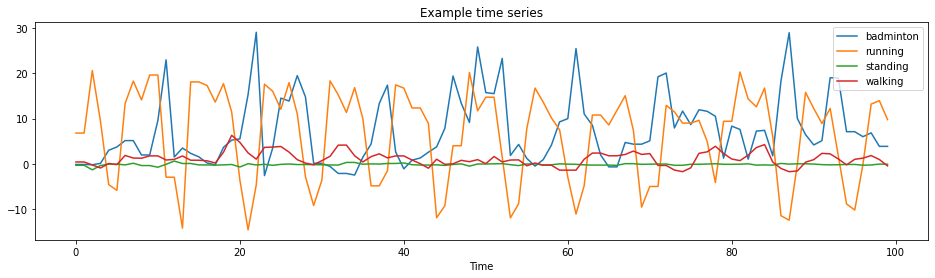

In [34]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=label)
plt.legend()
ax.set(title="Example time series", xlabel="Time");

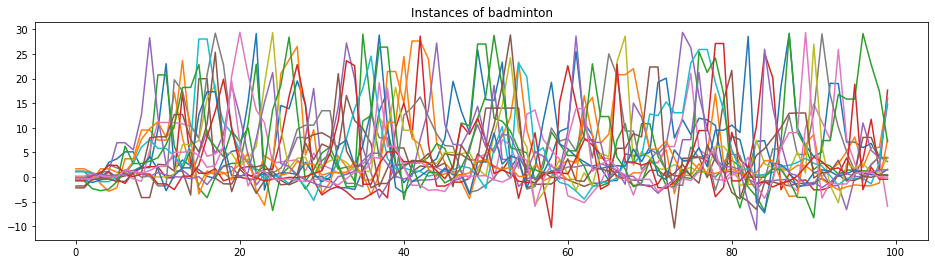

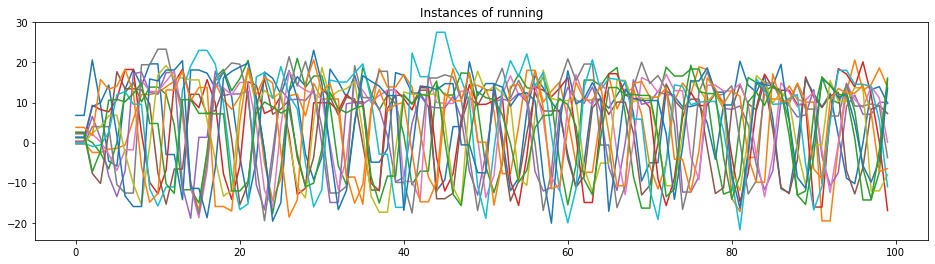

In [39]:
for label in labels[:2]:
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    for instance in X_train.loc[y_train == label, "dim_0"]:
        ax.plot(instance)
    ax.set(title=f"Instances of {label}")

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Tabularizer followed by sklearn's classifier.
knn = make_pipeline(
    Tabularizer(),
    KNeighborsClassifier(n_neighbors=1, metric="euclidean")
) 

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5

In [42]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

1.0

### Other classifiers

To find out what other algorithms we have implemented in `sktime`, you can use our utility function:

In [47]:
import pandas as pd
from IPython.display import display
from sktime.registry import allAnother approach is to use bespoke (or classifier-specific) methods for multivariate time series data. Here, we try out the MrSEQL algorithm in multidimensional space._estimators

with pd.option_context("display.max_colwidth", 100):
    display(all_estimators(estimator_types="classifier", as_dataframe=True))

,name,estimator
0,Arsenal,<class 'sktime.classification.kernel_based._arsenal.Arsenal'>
1,BOSSEnsemble,<class 'sktime.classification.dictionary_based._boss.BOSSEnsemble'>
2,CanonicalIntervalForest,<class 'sktime.classification.interval_based._cif.CanonicalIntervalForest'>
3,Catch22Classifier,<class 'sktime.classification.feature_based._catch22_classifier.Catch22Classifier'>
4,Catch22ForestClassifier,<class 'sktime.classification.hybrid._catch22_forest_classifier.Catch22ForestClassifier'>
5,ColumnEnsembleClassifier,<class 'sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier'>
6,ComposableTimeSeriesForestClassifier,<class 'sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier'>
7,ContractableBOSS,<class 'sktime.classification.dictionary_based._cboss.ContractableBOSS'>
8,DrCIF,<class 'sktime.classification.interval_based._drcif.DrCIF'>
9,ElasticEnsemble,<class 'sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble'>
